# Exploratory Data Analysis and Machine Learning with PySpark in an EMR Notebook

Today, we'll explore how you can use your PySpark coding skills in an [EMR Notebook](https://docs.aws.amazon.com/emr/latest/ManagementGuide/emr-managed-notebooks.html) on AWS. Specifically, we'll be working with all of the customer reviews for books in [Amazon's large customer reviews dataset on S3](https://s3.amazonaws.com/amazon-reviews-pds/readme.html). Note that this notebook is meant to be run on an EMR cluster, using a PySpark kernel.

First, let's load the customer book reviews data from S3 into our Spark session. The books data is spread across multiple parquet files (as we can see via the AWS CLI below), so we use the wildcard (\*) to indicate that we want the data from all of these files to be included within our dataframe, spread out over our EMR cluster in partitions.

In [ ]:
sc.install_pypi_package("boto3") # use boto3 to see book data in S3 bucket

In [2]:
import boto3

s3 = boto3.resource('s3')
bucket = 'amazon-reviews-pds'
bucket_resource = s3.Bucket(bucket)

for obj in bucket_resource.objects.all():
    if 'parquet' in obj.key and 'Books' in obj.key:
        print(obj.last_modified,"\t", round(obj.size * 1e-9), "GB\t",
              obj.key, "\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2018-04-09 06:35:58+00:00 	 1 GB	 parquet/product_category=Books/part-00000-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:35:59+00:00 	 1 GB	 parquet/product_category=Books/part-00001-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:00+00:00 	 1 GB	 parquet/product_category=Books/part-00002-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:00+00:00 	 1 GB	 parquet/product_category=Books/part-00003-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:00+00:00 	 1 GB	 parquet/product_category=Books/part-00004-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:33+00:00 	 1 GB	 parquet/product_category=Books/part-00005-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:35+00:00 	 1 GB	 parquet/product_category=Books/part-00006-495c48e6-96d6-4650-aa65-3c36a3516ddd.c000.snappy.parquet 

2018-04-09 06:36:35+00:00 	 1 GB	 parquet/product_categ

In [3]:
data = spark.read.parquet('s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now that we have our data loaded in a DataFrame, let's take a look at its structure and contents. We can see that there is a lot of data here (10 GB worth!), even in this small subset of the overall (~50 GB) Amazon Customer Reviews dataset.

In [4]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 15
Total Rows: 20726160
root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)

We can take a look at (preview) data from all of our columns at once (using `data.show()`), but this is a bit busy on the screen, so let's select a subset of the columns and take a look at the first 20 rows of our data.

In [5]:
data[['product_title', 'total_votes', 'star_rating']].show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+-----------+
|       product_title|total_votes|star_rating|
+--------------------+-----------+-----------+
|Standing Qigong f...|         10|          5|
|A Universe from N...|          7|          4|
|Hyacinth Girls: A...|          0|          4|
|        Bared to You|          1|          5|
|     Healer: A Novel|          0|          5|
|The Missionary Po...|          7|          4|
|I'm Tired of Bein...|          1|          4|
|Fifty Shades of G...|          7|          1|
|The Thrill of Vic...|          0|          4|
|Fifty Shades of G...|          9|          5|
|Romeo and Juliet ...|          0|          4|
|Wheat Belly: Lose...|          1|          5|
|Dangerous Dessert...|          0|          5|
|Consciousness Bey...|          0|          5|
|The Catcher in th...|          6|          1|
|Fearless: The Und...|          0|          4|
|Best-Ever Big Sister|          0|          5|
|      The Book Thief|          1|          5|
|  Large Prin

Using PySpark, we can calculate any number of additional summary statistics using standard SQL-like operations on our DataFrame.

In [6]:
stars_votes = (data.groupBy('star_rating')
                   .sum('total_votes', 'helpful_votes')
                   .sort('star_rating', ascending=False)
              )
stars_votes.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------------+------------------+
|star_rating|sum(total_votes)|sum(helpful_votes)|
+-----------+----------------+------------------+
|          5|        54808322|          44825468|
|          4|        13954363|          11100563|
|          3|        10117356|           7021927|
|          2|         9010874|           5581929|
|          1|        22624009|          10985502|
+-----------+----------------+------------------+

We can even plot the results of our summarizations using standard Python packages like Pandas and Seaborn. To do so within an EMR notebook, we will need to install these packages. If we list the packages currently available to us in our SparkContext, you can see that these packages are not already installed, so we will need to install them.

In [7]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

aws-cfn-bootstrap (2.0)
beautifulsoup4 (4.9.3)
boto (2.49.0)
boto3 (1.19.12)
botocore (1.22.12)
click (7.1.2)
docutils (0.14)
jmespath (0.10.0)
joblib (1.0.1)
lockfile (0.11.0)
lxml (4.6.2)
mysqlclient (1.4.2)
nltk (3.5)
nose (1.3.4)
numpy (1.16.5)
pip (9.0.1)
py-dateutil (2.2)
pystache (0.5.4)
python-daemon (2.2.3)
python-dateutil (2.8.2)
python37-sagemaker-pyspark (1.4.1)
pytz (2021.1)
PyYAML (5.4.1)
regex (2021.3.17)
s3transfer (0.5.0)
setuptools (28.8.0)
simplejson (3.2.0)
six (1.13.0)
tqdm (4.59.0)
urllib3 (1.26.7)
wheel (0.29.0)
windmill (1.6)

DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [ ]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")

In [9]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

aws-cfn-bootstrap (2.0)
beautifulsoup4 (4.9.3)
boto (2.49.0)
boto3 (1.19.12)
botocore (1.22.12)
click (7.1.2)
cycler (0.11.0)
docutils (0.14)
jmespath (0.10.0)
joblib (1.0.1)
kiwisolver (1.3.2)
lockfile (0.11.0)
lxml (4.6.2)
matplotlib (3.2.1)
mysqlclient (1.4.2)
nltk (3.5)
nose (1.3.4)
numpy (1.16.5)
pandas (1.0.3)
pip (9.0.1)
py-dateutil (2.2)
pyparsing (3.0.4)
pystache (0.5.4)
python-daemon (2.2.3)
python-dateutil (2.8.2)
python37-sagemaker-pyspark (1.4.1)
pytz (2021.1)
PyYAML (5.4.1)
regex (2021.3.17)
s3transfer (0.5.0)
scipy (1.4.1)
seaborn (0.10.1)
setuptools (28.8.0)
simplejson (3.2.0)
six (1.13.0)
tqdm (4.59.0)
urllib3 (1.26.7)
wheel (0.29.0)
windmill (1.6)

DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip

Now that our packages have been successfully installed, let's plot some of our data. Note, though, that because our data is so large, we do not want to send all of it into a Pandas DataFrame-- we want to take advantage of the distributed nature of our Spark DataFrame to perform any computations and then send only small segments of our data into Pandas and our plotting libraries, so that they will be able to handle it in-memory. Here, we use the `toPandas()` method to only send the small dataframe that summarizes the total number of votes for each star rating -- all of the computation was done on the Spark DataFrame.

It looks like 5 star reviews had a lot more "helpful" votes than all of the other star ratings.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

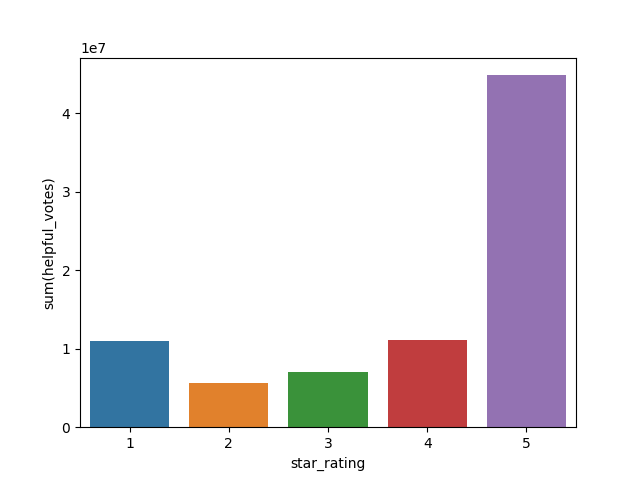

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

df = stars_votes.toPandas()

# Close previous plots; otherwise, will just overwrite and display again
plt.close()

sns.barplot(x='star_rating', y='sum(helpful_votes)', data=df)
%matplot plt

Given the order of magnitude difference in 5-star helpful votes, we might wonder whether there are simply more 5 star reviews than other star counts. It seems like there are indeed a lot more 5-star ratings than anything else.

In [11]:
stars = (data.groupBy('star_rating')
             .count()
             .sort('star_rating', ascending=False)
        )
stars.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------+
|star_rating|   count|
+-----------+--------+
|          5|13662131|
|          4| 3546319|
|          3| 1543611|
|          2|  861867|
|          1| 1112232|
+-----------+--------+

We can also take a random sample of our distributed dataset and send that sample to Pandas in order to plot it and get a sense of what it looks like. For instance, we can produce a scatter plot of a limited subset of our data using this strategy.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

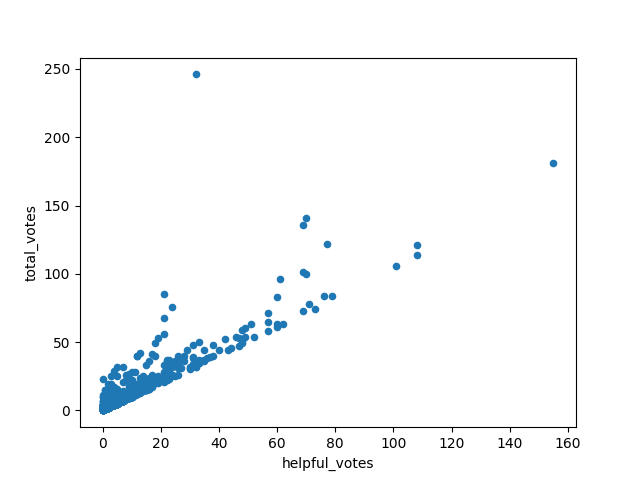

In [12]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

sampled_data = data.sample(fraction=0.0001)
sampled_df = sampled_data.toPandas()
sampled_df.plot.scatter('helpful_votes', 'total_votes')
%matplot plt

## Fitting a Machine Learning Model to Predict whether a Rating will be Good or Bad

Once we've explored our data, let's say that we want to fit a Machine Learning model to predict a review's star rating based on other features about the review. Here, let's fit a simple (and extremely naive, for the sake of demonstration) model that predicts whether or a customer review will have a "good" star rating (>= 4) or a "bad" star rating (<4) based on the total number of votes a review receives. In your homework, you will improve upon this model, engineering other features from the dataset, as well as doing a better job of balancing the data (see below -- there are a lot more "good" star-ratings than "bad" ones) and setting up a reproducible machine learning pipeline.

First, let's create a column that indicates whether a review is good or bad. We'll use this column as labels for machine learning. Note that we're working with a sampled subset of the data so that we can efficiently process the data during the class session.

In [20]:
# Good == 1, Bad == 0 (cast as integers so that pyspark.ml can understand them)
sampled_data = sampled_data.withColumn('good_review', (data.star_rating >= 4).cast("integer"))

# Check to make sure new column is capturing star_rating correctly
sampled_data[['star_rating', 'good_review']].show(5)

# Take a look at how many good and bad reviews we have, respectively
(sampled_data.groupBy('good_review')
     .count()
     .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+
|star_rating|good_review|
+-----------+-----------+
|          5|          1|
|          5|          1|
|          3|          0|
|          4|          1|
|          4|          1|
+-----------+-----------+
only showing top 5 rows

+-----------+-----+
|good_review|count|
+-----------+-----+
|          1| 1739|
|          0|  356|
+-----------+-----+

Then, let's use the `VectorAssembler` to get our total_votes feature into a form that `pyspark.ml` expects it to be in.

In [23]:
from pyspark.ml.feature import VectorAssembler

features = ['total_votes']
assembler = VectorAssembler(inputCols = features, outputCol = 'features')

sampled_data = assembler.transform(sampled_data)
sampled_data[['good_review', 'total_votes', 'features']].show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+--------+
|good_review|total_votes|features|
+-----------+-----------+--------+
|          1|          1|   [1.0]|
|          1|          0|   [0.0]|
|          0|          1|   [1.0]|
|          1|          0|   [0.0]|
|          1|          0|   [0.0]|
|          1|          0|   [0.0]|
|          0|          9|   [9.0]|
|          0|          0|   [0.0]|
|          1|          0|   [0.0]|
|          1|          0|   [0.0]|
|          1|          4|   [4.0]|
|          1|          2|   [2.0]|
|          1|          2|   [2.0]|
|          1|          0|   [0.0]|
|          1|          0|   [0.0]|
|          1|          0|   [0.0]|
|          1|          2|   [2.0]|
|          1|          0|   [0.0]|
|          1|          0|   [0.0]|
|          1|          1|   [1.0]|
+-----------+-----------+--------+
only showing top 20 rows

Then, we split up our data into training and test data and train a logistic regression model on our training data.

In [24]:
from pyspark.ml.classification import LogisticRegression

train, test = sampled_data.randomSplit([0.7, 0.3])

lr = LogisticRegression(featuresCol='features', labelCol='good_review')
model = lr.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And, finally, we can make predictions for our test data and see how good our model is. Note that our predictive accuracy is not bad overall. However, from our "false positive rate by label" metric, we can see that our model is essentially just predicting that most reviews will be "good" reviews (label 1) -- likely because of our highly unbalanced data (and perhaps use of only a small sample of the data). Accordingly, you'll notice that our AUC is only a bit above .5 (see ROC Curve below). In Assignment 3, it'll be your job to try to improve this model, so that we can better distinguish good from bad customer reviews.

In [25]:
# Training Summary Data
trainingSummary = model.summary
evaluationSummary = model.evaluate(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
print("Training AUC: " + str(trainingSummary.areaUnderROC))
print("Test AUC: ", str(evaluationSummary.areaUnderROC))

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
    
print("\nTraining Accuracy: " + str(trainingSummary.accuracy))
print("Test Accuracy: ", str(evaluationSummary.accuracy))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.6907530284469853
Test AUC:  0.674430070865089

False positive rate by label (Training):
label 0: 0.01181434599156118
label 1: 0.9233870967741935

True positive rate by label (Training):
label 0: 0.07661290322580645
label 1: 0.9881856540084388

Training Accuracy: 0.8304256803907886
Test Accuracy:  0.8368580060422961

In [27]:
# Get ROC curve and send it to Pandas so that we can plot it
roc_df = evaluationSummary.roc.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

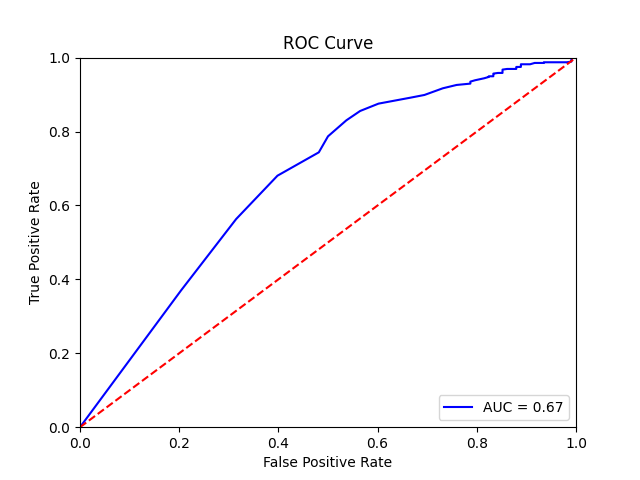

In [28]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

plt.plot(roc_df.FPR, roc_df.TPR, 'b', label = 'AUC = %0.2f' % evaluationSummary.areaUnderROC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt